In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

df1 = pd.read_csv('Datasets\\ALLFLOWMETER_HIKARI2021.csv')
df2 = pd.read_csv('Datasets\\ALLFLOWMETER_HIKARI2022.csv')

#df1.drop('bwd_last_window_size', axis=1)

# Combining two IDS datasets acquired over 2 years to develop good model
combined_df = pd.concat([df1, df2], ignore_index=True)

# we remove the 'flow_duration' here too because it has no real impact on the analysis and the formats are very different from same
# synthetic dataset reproduced as shown in paper.
combined_df = combined_df.drop(['Unnamed: 0', 'uid', 'flow_duration','bwd_last_window_size'], axis=1)

combined_df['attack_category'] = combined_df['attack_category'].str.strip()
# Replacing similar values with correct version
combined_df['attack_category']=combined_df['attack_category'].replace('Brutefoce', 'Bruteforce')

attack_category_counts = combined_df['attack_category'].value_counts()
print("Attack categories:",attack_category_counts)

y = combined_df['Label']

X = combined_df.drop(['Label', 'originh', 'responh'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

# Names of columns with missing values
cols_with_missing_values = [col for col in X_train.columns
                            if X_train[col].isnull().any()]

print("Columns with missings values:",cols_with_missing_values)
# With prelimnary analysis we found that there were no missing values in any 
# of the columns. Hence, it is a robust dataset.

#getting list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables")
print(object_cols)

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Removing the categorical columns (will be replacing with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)

rfc_model = RandomForestClassifier(n_estimators=100, random_state=0)
rfc_model.fit(OH_X_train, y_train)

predictions = rfc_model.predict(OH_X_valid)

accuracy = accuracy_score(y_valid, predictions)

print("Accuracy: ", accuracy)
print("Classification Report:")
print(classification_report(y_valid, predictions))

C:\Users\swapn\AppData\Local\Temp\ipykernel_16412\283925697.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Attack categories: attack_category
Benign                 562335
Background             170151
Probing                 23388
Bruteforce-XML           8795
Bruteforce               7988
XMRIGCC CryptoMiner      7595
Name: count, dtype: int64
Columns with missings values: []
Categorical variables
['attack_category']
Accuracy:  1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    112433
           1       1.00      1.00      1.00      9572
           2       1.00      1.00      1.00     34046

    accuracy                           1.00    156051
   macro avg       1.00      1.00      1.00    156051
weighted avg       1.00      1.00      1.00    156051



Training Accuracy: 1.0
Validation Accuracy: 1.0
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    449902
           1       1.00      1.00      1.00     38194
           2       1.00      1.00      1.00    136105

    accuracy                           1.00    624201
   macro avg       1.00      1.00      1.00    624201
weighted avg       1.00      1.00      1.00    624201

Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    112433
           1       1.00      1.00      1.00      9572
           2       1.00      1.00      1.00     34046

    accuracy                           1.00    156051
   macro avg       1.00      1.00      1.00    156051
weighted avg       1.00      1.00      1.00    156051



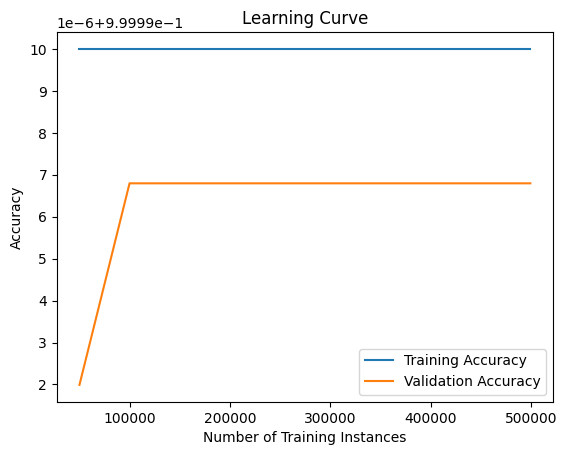

In [5]:
import numpy as np
from sklearn.model_selection import learning_curve


# Train a Random Forest Classifier
rfc_model = RandomForestClassifier(n_estimators=100, random_state=0)
rfc_model.fit(OH_X_train, y_train)

# Predictions on training and validation sets
train_predictions = rfc_model.predict(OH_X_train)
valid_predictions = rfc_model.predict(OH_X_valid)

# Compute performance metrics
train_accuracy = accuracy_score(y_train, train_predictions)
valid_accuracy = accuracy_score(y_valid, valid_predictions)

train_classification_report = classification_report(y_train, train_predictions)
valid_classification_report = classification_report(y_valid, valid_predictions)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", valid_accuracy)

print("Training Classification Report:")
print(train_classification_report)

print("Validation Classification Report:")
print(valid_classification_report)

# Plot learning curves
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=rfc_model,
    X=OH_X_train,
    y=y_train,
    train_sizes=train_sizes,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, valid_mean, label='Validation Accuracy')
plt.xlabel('Number of Training Instances')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

df1 = pd.read_csv('Datasets\\ALLFLOWMETER_HIKARI2021.csv')
df2 = pd.read_csv('Datasets\\ALLFLOWMETER_HIKARI2022.csv')

#df1.drop('bwd_last_window_size', axis=1)

# Combining two IDS datasets acquired over 2 years to develop good model
combined_df = pd.concat([df1, df2], ignore_index=True)

# we remove the 'flow_duration' here too because it has no real impact on the analysis and the formats are very different from same
# synthetic dataset reproduced as shown in paper.
combined_df = combined_df.drop(['Unnamed: 0', 'uid', 'flow_duration','bwd_last_window_size'], axis=1)

combined_df['attack_category'] = combined_df['attack_category'].str.strip()
# Replacing similar values with correct version
combined_df['attack_category']=combined_df['attack_category'].replace('Brutefoce', 'Bruteforce')

# Stratified split for training and validation sets
X = combined_df.drop(['Label', 'originh', 'responh'], axis=1)
y = combined_df['Label']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# ... your code for handling categorical variables (object_cols, OH_encoder) ...
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Removing the categorical columns (will be replacing with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

OH_X_train = pd.concat([X_train.drop(object_cols, axis=1), OH_cols_train], axis=1)
OH_X_valid = pd.concat([X_valid.drop(object_cols, axis=1), OH_cols_valid], axis=1)

OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)

# K-Fold Cross-Validation with F1-score evaluation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)  # 5-fold stratified cross-validation
f1_scores = []
for train_index, test_index in kfold.split(OH_X_train, y_train):
  # Train on fold data
  fold_train_x, fold_train_y = OH_X_train.iloc[train_index], y_train.iloc[train_index]
  rfc_model = RandomForestClassifier(n_estimators=100, random_state=0)
  rfc_model.fit(fold_train_x, fold_train_y)

  # Make predictions on validation fold data
  fold_test_x, fold_test_y = OH_X_train.iloc[test_index], y_train.iloc[test_index]
  predictions = rfc_model.predict(fold_test_x)

  # Calculate F1-score
  f1 = f1_score(fold_test_y, predictions, average='weighted')
  f1_scores.append(f1)

# Print average F1-score across folds
print("Average F1-score (KFold):", np.mean(f1_scores))

# Confusion Matrix on validation set
y_pred = rfc_model.predict(OH_X_valid)
confusion_matrix = confusion_matrix(y_valid, y_pred)
print("Confusion Matrix:\n", confusion_matrix)

# Classification Report on validation set (using F1-score)
print("Classification Report:")
print(classification_report(y_valid, y_pred))


Average F1-score (KFold): 0.9999967957069185
Confusion Matrix:
 [[112468      0      0]
 [     0   9553      0]
 [     0      0  34030]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    112468
           1       1.00      1.00      1.00      9553
           2       1.00      1.00      1.00     34030

    accuracy                           1.00    156051
   macro avg       1.00      1.00      1.00    156051
weighted avg       1.00      1.00      1.00    156051



In [8]:
print("new commit")

new commit
